Here we analyze the raw data obtained from the _QPC_dd_sim.py_ script.

In [151]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.insert(1, '/Users/rasputin/Desktop/Uni/PhD/hoping_chain_tensors/scripts')

from qutip_tools import *


In [152]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [153]:
def get_partial_trace(Psi, NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2 ** (NN - 2)  # QPC sites
    m = 2 ** 2  # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n, m, n, m), axis1=0, axis2=2))



def get_file_names_on(param_list, route):
    name_list = os.listdir(route)
    try:
        name_list.remove('.DS_Store')
    except:
        pass
    # gets a list of the hdf5 file names with t dependent data depending on the values in param_list
    for subs in param_list:
        # getting strings with parameters that we want
        name_list = list(filter(lambda x: subs in x, name_list))
    return name_list

In [154]:
data_route = "../data/sims/L=21/"
J=1


# Load processed data dataframe

In [155]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_full_df))
data_full_df.head()



Number of data points: 1398


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,bond_density_max,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,0.535270,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.543778,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,3.135010
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.367979,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,1.139764
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.541525,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.046250
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.363672,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,3.028592


Notice how the elements with time at bond < 0 are those with negative hitting times which correspond to negative velocities. Thi si clearly beyond the regime that we care about so we should ignore them

In [156]:
data_full_df[data_full_df["time_f_int"]<0].describe()
data_full_df = data_full_df[data_full_df["vg"]>0]

# here we can choose wether we want just the "fixed" by k0 initial conditions
# or the fully localized "second"
data_df = data_full_df[data_full_df["ddot0"]=="fixed"]


In [157]:
print(data_df.columns)

print("omega")
print(data_df['Omega'].unique())
print("t")
print(data_df['t'].unique())
print(data_df['k0'].unique())


Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi'],
      dtype='object')
omega
[0.4  0.01 0.5  0.05 0.1  0.   0.7  0.3  0.2 ]
t
[0.   0.4  0.2  0.1  0.3  0.01 0.8  0.5  0.7  0.6  0.9  0.05 1.  ]
[0.39269908 0.9817477  1.37444679 1.17809725 1.57079633 0.78539816
 0.52359878]


# Entanglement

## Making sure that QPC particles with different velocities hit the bond when the dot is at the same state

In [158]:
file_list = get_file_names_on(["om0.0","bw2.0","t0.3", "dd0fixed"], data_route)

file_list

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.3_om0.05_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.3_om0.01_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.3_om0.0_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.3927_jp1.0_t0.3_om0.01_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.3927_jp1.0_t0.3_om0.05_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.3744_jp1.0_t0.3_om0.0_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.3_om0.0_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.9817_jp1.0_t0.3_om0.01_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.9817_jp1.0_t0.3_om0.05_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.3_om0.01_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.3_om0.05_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.3_om0.05_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.9817_jp1.0_t0.3_om0.0_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.3_om0.01_dd0fixed.hdf5',
 'res_L21_maxtim18.0_bw2.0_k0.7854_jp1

phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values


Text(0.5, 0, 'Time')

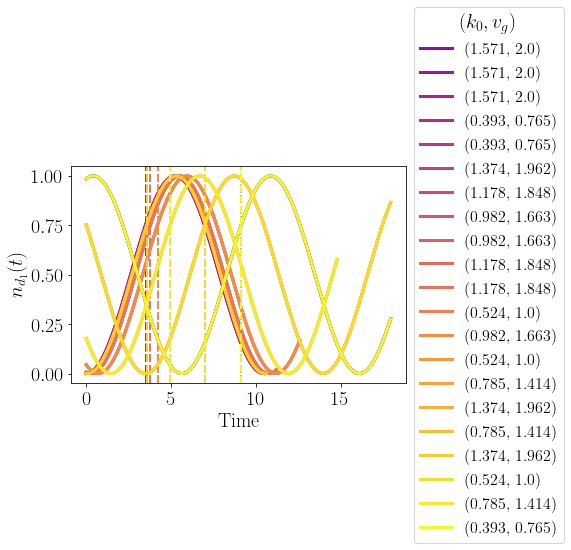

In [159]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, n_bond, n_left, n_right, n_d1, \
        n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,file_name)
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["k0"])
    tau_to_bond = param_dict["bond_index"]/vg
    
    lab = "("+str(round(param_dict["k0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(times, n_d1, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



## constant omega, constant t constant bandwidth so we can look at **varying $k_0$**

In [160]:
om_s = "om0.3"
bw_s = "bw2.0"
t_s = "t0.1"

file_list = get_file_names_on([om_s, bw_s,t_s, "dd0fixed"], data_route)
# sort from slowest to fastest
file_list = sorted(file_list)


phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values
phi is undefined using next values


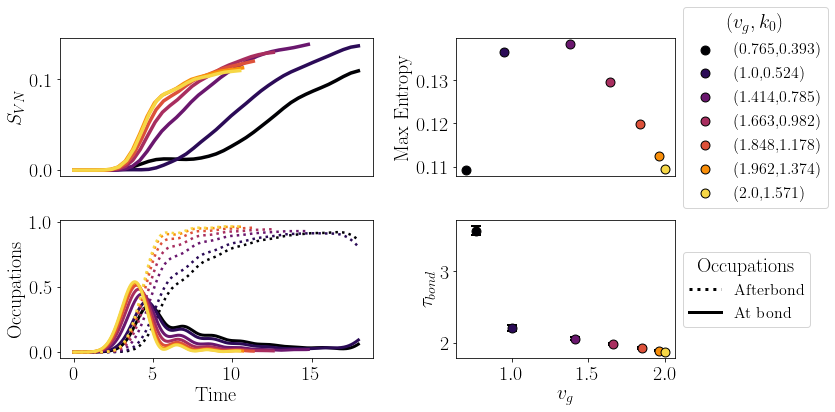

In [161]:
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(file_list)))

# Create 2x2 sub plots

plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])


for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times,n_bond, n_left, n_right, n_d1, \
        n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,file_name)

    # calculate data for the time scales
    tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)   
    
    # calculate the time it takes it to hit the bond (scattering approx)
    tau_to_bond = param_dict["bond_index"]/vg
    # condition to get error bars for tau_b from df
    cond = (data_df["t"] == param_dict["t"]) & (data_df["Omega"] == param_dict["Omega"]) \
            & (data_df["x_spread"] == param_dict["band_width"])

    
    k0 = param_dict["k0"]
    lab = "(" + str(round(vg,3)) + "," + str(round(k0,3)) + ")"
    
    # for the entropy
    times_coarse = np.linspace(0,max(times), len(VN_entropy))
    
    # plot first row
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    ax.plot(times_coarse, VN_entropy, linewidth=3.5, c=colors[i])
    ax.set_ylabel(r"$S_{VN}$")
    ax.set_xticks([])
    
    ax = plt.subplot(gs[0, 1])
    ax.scatter(vg, max(VN_entropy), c=[colors[i]], s=80, edgecolor='black', label=lab, zorder=7)
    ax.legend(title=r"$(v_g, k_0)$", loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticks([])
    ax.set_ylabel(r"Max Entropy")

    # plot second row
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(times,n_right, linewidth=2.5, linestyle="dotted", c=colors[i])  
    ax.plot(times,n_bond, label=lab, linewidth=3, c=colors[i])
    
        
    ax.set_ylabel(r"Occupations")
    ax.set_xlabel(r"Time")

    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    
    # Add error bars 
    ax.errorbar(data_df[cond]["vg"], data_df[cond]["time_at_bond"], yerr=data_df[cond]["bond_fit_error"], 
            fmt="x", elinewidth=3,ecolor='black', capsize=5, capthick=2)
    
    ax.scatter(vg, tau_b, c=[colors[i]], s=80, edgecolor='black', zorder=7)
    ax.set_ylabel(r"$\tau_{bond}$")
    ax.set_xlabel(r"$v_g$")
    
# indicate what the solid lines mean
ax.plot(0.7,2, linestyle="dotted", linewidth=3.0 ,c="black",label="Afterbond")
ax.plot(0.7,2, linestyle="solid", linewidth=3.0 , c="black",label="At bond")
ax.legend(title="Occupations", loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplots_adjust(wspace=0.16, hspace=0.08)
plt.tight_layout()

plt.savefig(fig_route+"entropy_summary_{}_{}_{}.pdf".format(om_s, bw_s,t_s))


## Backaction on the Bloch Sphere

In [186]:
data_df[cond][["time_at_bond","k0"]]

,time_at_bond,k0
161,1.925212,1.178097
191,1.886883,1.374447
340,1.873209,1.570796
921,1.982531,0.981748
1023,2.053554,0.785398
1045,3.569367,0.392699
1341,2.207464,0.523599


In [191]:
data_df[cond].sort_values(by="k0")

,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,bond_density_max,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi
1045,21,18.0,400,7,2.0,0.392699,1.0,0.1,0.3,0.765367,...,0.359124,0.955220,0.109178,10,0.870708,fixed,0.513814,2.259272,1.150380,0.239717
1341,21,18.0,400,7,2.0,0.523599,1.0,0.1,0.3,1.000000,...,0.387101,0.940764,0.136654,10,0.849893,fixed,0.490927,2.575374,0.801940,0.239276
1023,21,18.0,400,7,2.0,0.785398,1.0,0.1,0.3,1.414214,...,0.444227,0.939862,0.138312,10,0.843028,fixed,0.413719,2.460037,0.934000,0.285948
921,21,18.0,400,7,2.0,0.981748,1.0,0.1,0.3,1.662939,...,0.482155,0.944597,0.129540,10,0.832665,fixed,0.381253,2.205841,1.118728,0.287836
161,21,18.0,400,7,2.0,1.178097,1.0,0.1,0.3,1.847759,...,0.512378,0.949747,0.119794,10,0.830174,fixed,0.361427,2.041246,1.196068,0.290948
191,21,18.0,400,7,2.0,1.374447,1.0,0.1,0.3,1.961571,...,0.532132,0.953536,0.112474,10,0.829135,fixed,0.349297,2.002557,1.225632,0.294456
340,21,18.0,400,7,2.0,1.570796,1.0,0.1,0.3,2.000000,...,0.539132,0.955062,0.109488,10,0.831857,fixed,0.345388,1.931847,1.244586,0.294621


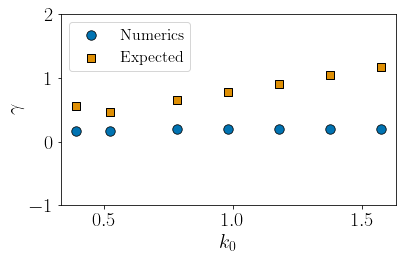

In [198]:
om_ = 0.2
bw_ = 2.0
t_ = 0.1

cond = (data_df["t"] == t_) & (data_df["x_spread"] == bw_) & (data_df["Omega"] == om_)

sorted_df = data_df[cond].sort_values(by="k0")
expected_change = 2*sorted_df["time_at_bond"]*sorted_df["k0"]*om_ 

sns.scatterplot(data = data_df[cond], x="k0" ,y="delta_phi",edgecolor='black' ,s=90, label="Numerics")
plt.scatter(sorted_df["k0"], expected_change, marker="s", s=80, edgecolor="black", label="Expected")
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$k_0$")

plt.ylim(-1, 2)

plt.legend()
plt.tight_layout()

plt.savefig(fig_route+"extra_phase_om={}_bw={}_t={}.pdf".format(om_, bw_,t_))



# Dataframe summary

## Correlation Matrix


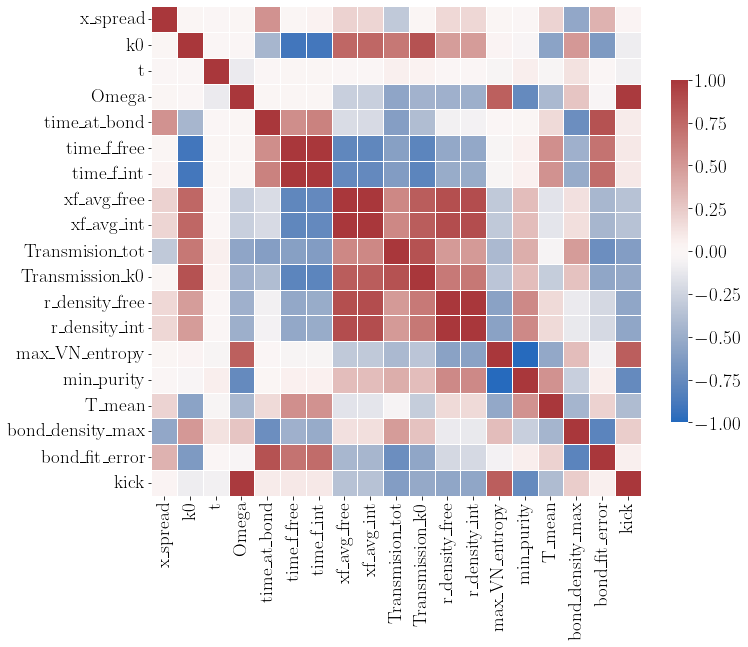

In [64]:
rel_params = ["x_spread","k0","t", "Omega"]
rel_results = ['time_at_bond', 'time_f_free',
       'time_f_int', 'xf_avg_free', 'xf_avg_int', 'Transmision_tot',
       'Transmission_k0', 'r_density_free', 'r_density_int',"max_VN_entropy","min_purity", 
        "T_mean", "bond_density_max","bond_fit_error", "kick"]
corr = data_df[rel_params+rel_results].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, square=True, linewidths=.5, vmin=-1, vmax=1 ,cmap = "vlag",cbar_kws={"shrink": .7})


plt.savefig(fig_route+"correlations.pdf")



## Time at bond

<AxesSubplot:xlabel='x_spread', ylabel='vg'>

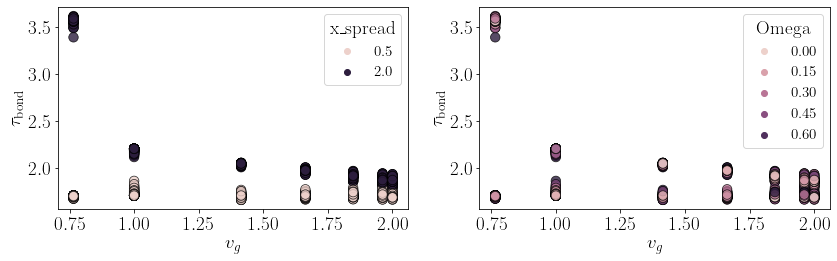

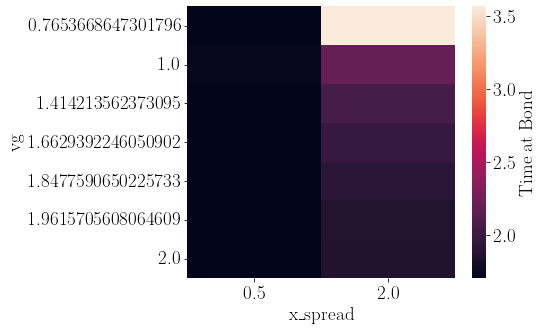

In [65]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="vg", y="time_at_bond",hue="x_spread" , s=90,alpha=0.8,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="vg", y="time_at_bond",hue="Omega" ,s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$v_g$")
ax[0].set_ylabel(r"$\tau_{\rm{bond}}$")

ax[1].set_xlabel(r"$v_g$")
ax[1].set_ylabel(r"$\tau_{\rm{bond}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="vg", columns="x_spread", values="time_at_bond")

sns.heatmap(bondmap,cbar_kws={'label': "Time at Bond"})

## Hitting time

make a density plot to get the correlations between the sim parameters and observed values. 
To see some kinf of relationship between the values we probably have to work by keeping one parameter or more parameter constant and then varying the rest, We can use hues for this.

Compare the time_last_density with the other two estimated times.
Also look at the maximum average x

1. Distringuish between values of omega and dot hopping because these change everything
2. compare the two estimated times with the density time
3. compare the maximum average x ant the group velocity x
4. compare the transmission coeffients


<AxesSubplot:xlabel='x_spread', ylabel='vg'>

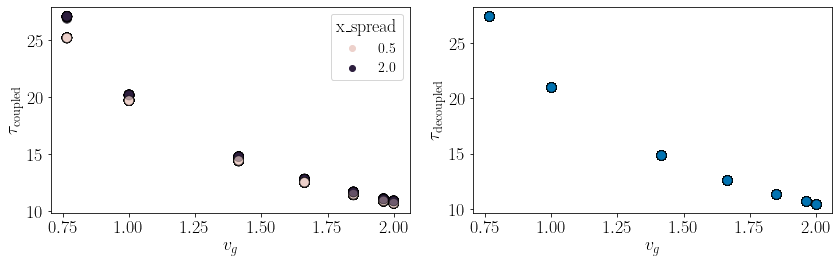

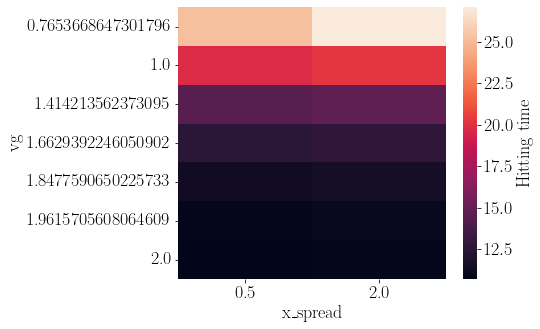

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="vg", y="time_f_int",hue="x_spread" , s=90, alpha=0.6,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="vg", y="time_f_free",s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$v_g$")
ax[0].set_ylabel(r"$\tau_{\rm{coupled}}$")

ax[1].set_xlabel(r"$v_g$")
ax[1].set_ylabel(r"$\tau_{\rm{decoupled}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="vg", columns="x_spread", values="time_f_int")

sns.heatmap(bondmap,cbar_kws={'label': "Hitting time"})


# Transmision probability and density at bond

Average the transmision probability from 6 to 10 to get rid of those finite size effects and pick a values tht makes a bit more sense

<AxesSubplot:xlabel='k0', ylabel='bond_density_max'>

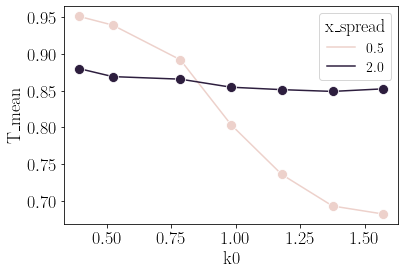

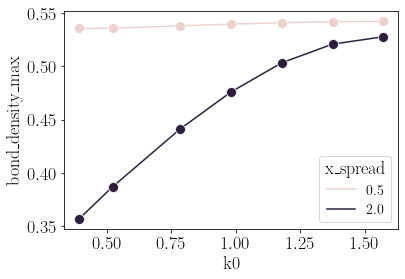

In [16]:
plt.figure()

cond = (data_df['Omega']==0.3) & (data_df['t']==0.0)
curr_df = data_df[cond].sort_values(by="k0")
sns.lineplot(data = curr_df, x="k0", y="T_mean", hue="x_spread", marker='o', markersize=10)

plt.figure()
sns.lineplot(data=curr_df, x="k0", y="bond_density_max", hue="x_spread", marker='o', markersize=10)

# Max entropy production

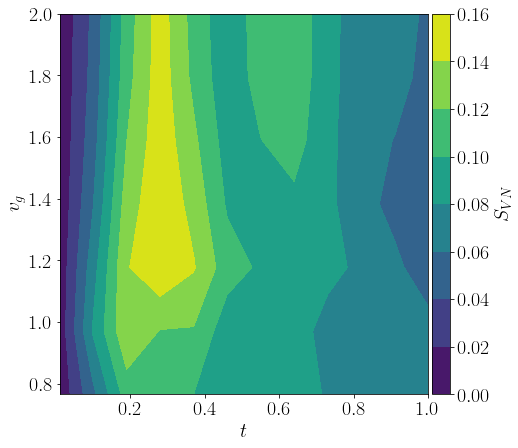

In [113]:
 cond = (data_df["Omega"] == 0.3) & (data_df["x_spread"]==2.0) & (data_df["t"]>0)

S_df = data_df[cond].pivot(index="vg", columns="t", values="max_VN_entropy")

#sns.heatmap(S_df, annot=True ,fmt='.3f')


fig, ax = plt.subplots(1,1,figsize=(bwidth,bwidth))


vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values,extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)])

ax.set_ylabel(r"$v_g$")
ax.set_xlabel(r"$t$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}$', rotation=90)

plt.savefig(fig_route+"entropy_phase_diagram_L_={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


## Several different variables

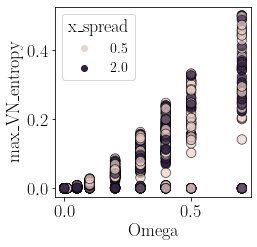

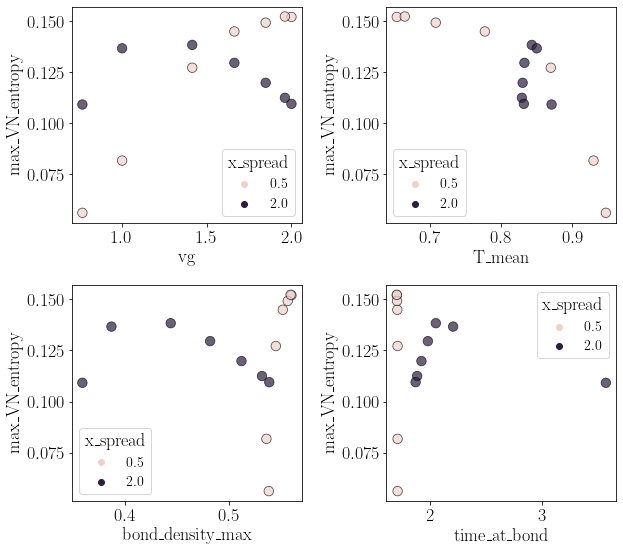

In [18]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5))
sns.scatterplot(data=data_df, x="Omega", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,edgecolor='black')

# choose a specific Omega
chosen_omega = 0.2
cond = (data_df["Omega"]==0.3) & (data_df["t"]==0.1) 
curr_df = data_df[cond]

fig, ax = plt.subplots(2,2, figsize=(9,8))

sns.scatterplot(data=curr_df, x="vg", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,edgecolor='black',
                ax=ax[0,0])

sns.scatterplot(data=curr_df, x="T_mean", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7, 
                edgecolor='black',ax=ax[0,1])

sns.scatterplot(data=curr_df, x="bond_density_max", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,
                edgecolor='black',ax=ax[1,0])


sns.scatterplot(data=curr_df, x="time_at_bond", y="max_VN_entropy",hue="x_spread" , s=90, alpha=0.7,
                edgecolor='black',ax=ax[1,1])

plt.tight_layout()

## Kick

Which I define as $$\Omega \int dt\, n(t) \propto S_{VN}$$

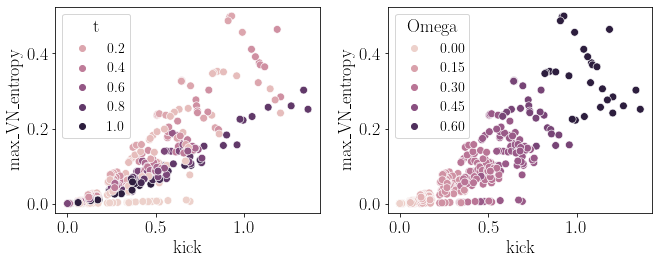

In [19]:
fig, ax = plt.subplots(1,2, figsize=(9.5,4))

cond = (data_df["x_spread"]==2.0) & (data_df["t"]>0)

sns.scatterplot(data=data_df[cond], x="kick", y="max_VN_entropy", hue="t", s=60, ax=ax[0])
sns.scatterplot(data=data_df[cond], x="kick", y="max_VN_entropy", hue="Omega", s=60, ax=ax[1])

plt.tight_layout()



Text(0, 0.5, 'Kick')

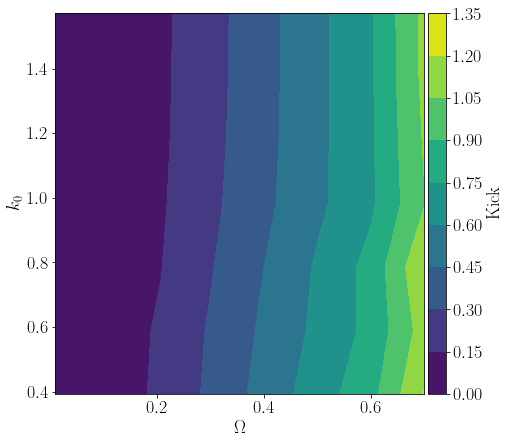

In [20]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bwidth))

cond = (data_df["t"] == 0.3) & (data_df["x_spread"]==2.0) & (data_df["Omega"]>0.0)

cplot = data_df[cond].pivot(index="k0", columns="Omega", values="kick")

k0_array = cplot.index
Omega_array = cplot.columns
im = ax.contourf(cplot.values,extent=[min(Omega_array), max(Omega_array),min(k0_array), max(k0_array)])

ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$\Omega$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'Kick', rotation=90)



# Individual examples

Test with the analytic scattering aplitude

In [94]:
"res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

file_name = "res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity,\
                dd_costheta, dd_sinphi = load_data(data_route,file_name)
J=1

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


phi is undefined using next values


## Timescales of the system

Three different times: time it takes to reach the bond, time spent at bond and time to gor from bond to the end.

The time at the bond is found as the full width at half-maximum of the bond occupations. The others are approximated as a freely propagating wave with the grpup velocity of the tight binding chain

For full width at half max: https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak

In [95]:
a = [1,2,3,4]
a[::2]

[1, 3]

estimated time to hit the far wall with coupling:  14.781476083573445
estimated time to hit the far wall without coupling:  14.849242404917499


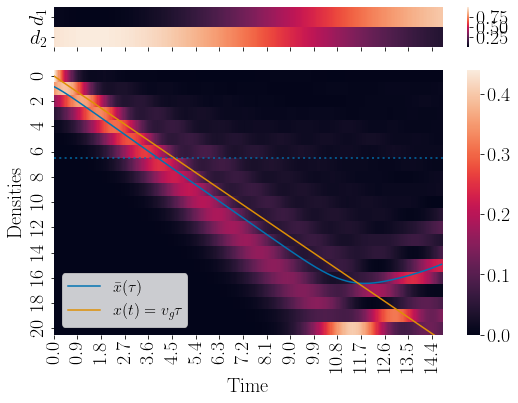

In [96]:

print("estimated time to hit the far wall with coupling: ", tau_L)
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
sns.heatmap([n_d1,n_d2],ax=ax[0])

# plot the occupations as a heatmap with lattice site in the y axis and time on the x
sns.heatmap(traject,ax=ax[1])

ax[1].plot(x_av+0.5,label=r"$\bar{x}(\tau)$") # the 0.5 is so the values correspond to the ticks so its easier to visualize
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")
# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]
"""ax[1].axvline(tau_L/delta_tau, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax[1].axvline(tau_free/delta_tau, label=r"$\tau_{free}$", linestyle="dashed", c="pink")"""

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Densities")

ax[1].axhline(param_dict["bond_index"], alpha=0.7,linestyle='dotted' ,linewidth=2.0)

# lattice ticks
ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])

site_ticks = list(range(0,param_dict["L_qpc"]))[::2] 
tick_posy = 2*np.asarray(range(0,len(site_ticks))) + 0.5
ax[1].set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
plt.tight_layout()

plt.savefig(fig_route+"traj_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.png".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]), dpi = 300)



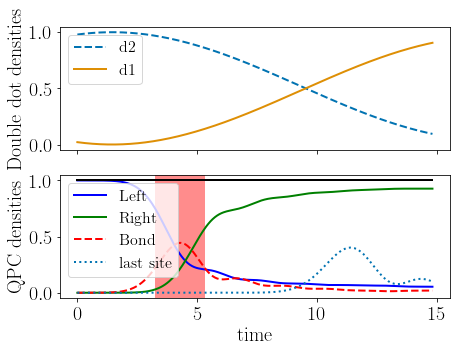

In [97]:
fig, ax = plt.subplots(2,1, figsize=(7,5),sharex=True)
t = param_dict["t"]
bond_index = param_dict["bond_index"]
k_prime = param_dict["k0"]
tskip = param_dict["entropy_t_skip"]

phi = -np.pi/2

a0 = np.cos( (t*bond_index)/(2*J)*(1/np.sin(k_prime) - 1) )
b0 = - 1j*np.sin( (t*bond_index)/(2*J)*(1/np.sin(k_prime) - 1) )*np.exp(1j*phi)

psi0_t = 0.5*(a0+b0*np.exp(-1j*phi))*np.exp(-1j*t*times) + 0.5*(a0-b0*np.exp(-1j*phi))*np.exp(1j*t*times)

rabi_osc = psi0_t*np.conj(psi0_t)

# in dot
# ax[0].plot(times, rabi_osc.real, linewidth=2.0, alpha=1.0, c='black' ,label="d2")
ax[0].plot(times, n_d2, linewidth=2.0, alpha=1.0, linestyle="dashed" ,label="d2")
ax[0].plot(times, n_d1, linewidth=2.0, alpha=1.0, label="d1")

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,traject[-1],label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black'
        ,linewidth=2)

# plot full width at half maximum at bond
ax[1].axvspan(bond_root[0], bond_root[1], facecolor='r', alpha=0.45)

ax[0].legend()
ax[0].set_ylabel("Double dot densities")

ax[1].set_xlabel("time")
ax[1].set_ylabel("QPC densities")
ax[1].legend()

plt.savefig(fig_route+"densities_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))



## Bloch sphere visualization

By comparing the reduced density matrix of the double dot in the decoupled and coupled cases in the bloch representation we can get a better idea of what the backaction is doing here. For comparisson we also calcualte the quantities for an analogous decoupled system.

Notice that the coupled case, only plots the vectors in one side of the sphere and the ones that should be on the otherside are also flipped there. The reason is that we use arccos to get those angles which only has a rnage from -1 to 1 between -pi/2 to pi/2 and as a result it ends up projecting the oscillations beyond the cosine period onto the same range of angles 


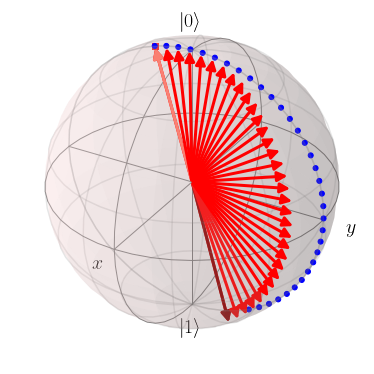

'plt.savefig(fig_route+"Bloch_sphere_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(\n            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],\n            param_dict["J_prime"], param_dict["Omega"]))'

In [102]:
# First the decoupled system
# now generate the expected free oscillations
w = param_dict["t"]

# accounting for the different possible initial conditions
theta0 = 2*np.arccos(a0) 
times_coarse = np.linspace(0,max(times), len(dd_costheta))
theta_free = -theta0+2*w*times_coarse
phi_free = np.pi/2

# writting out free case solution in spherical coordinates
x_ = np.sin(theta_free)*np.cos(phi_free)
y_ = np.sin(theta_free)*np.sin(phi_free)
z_ = np.cos(theta_free)

# the + pi in the angle is because we start the system in the 1 state instead of the 0 
free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]]

# Now plot the numerical coupled case
dd_theta = np.arccos(dd_costheta)
dd_phi = np.arcsin(dd_sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = dd_costheta

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

bs = Bloch()

bs.add_points(free_points)
bs.add_points(free_first)

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color

bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])

bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]

bs.show()
bs.save(fig_route+"Bloch_sphere_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))

"""plt.savefig(fig_route+"Bloch_sphere_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))"""

When dealing with plotting the Bloch angles, we have to be mindful that python projects the arcos alwasy between 0 to pi, this affects both the $\beta$ and $\eta$ values, our initial condition that we have chosen for phi is $\eta_0 = \pi/2$ and we should see a deviation from this. Just keep in mind that that large sudden jumps in phi are due to completed periods

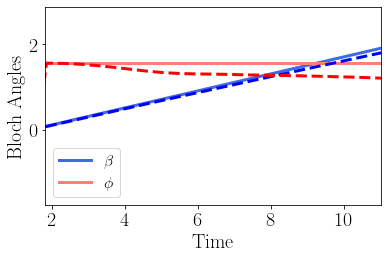

In [110]:
tskip = param_dict["entropy_t_skip"]


dt = times_coarse[1] - times_coarse[0]
D_dd_theta = np.gradient(dd_theta.real, dt, edge_order=2)
D_dd_phi= np.gradient(dd_phi.real, dt, edge_order=2)

D_theta_free = np.gradient(theta_free.real, dt, edge_order=2)


fig, ax = plt.subplots(1,1,figsize=(6,4))
# plot where pi is at
ax.plot(times_coarse, theta_free, c='royalblue', linewidth=3, label=r"$\beta$")
ax.axhline(phi_free, c = "salmon",linewidth=3, label=r"$\phi$")

ax.plot(times_coarse, dd_theta.real, c='blue', linestyle="dashed", linewidth=3)
ax.plot(times_coarse, dd_phi.real, c='red', linestyle="dashed", linewidth=3)

"""ax[1].plot(times_coarse, D_theta_free, c='royalblue', linewidth=3, label=r"$\beta$")
ax[1].axhline(0, c = "salmon",linewidth=3, label=r"$\theta$")
ax[1].plot(times_coarse, D_dd_theta, c='blue', linestyle="dashed", linewidth=3)
ax[1].plot(times_coarse, D_dd_phi, c='red', linestyle="dashed", linewidth=3)
"""
ax.set_xlim(1.81,11)

ax.legend()
ax.set_xlabel(r"Time")
ax.set_ylabel(r"Bloch Angles")

plt.tight_layout()
plt.savefig(fig_route+"Bloch_angles_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))

## Comparisson with Scattering Calculations

For small enough $t$ (double dot hopping) we can approximate the bond pottential as a constant delta function potential. Therefore we can compare to some analytical results using scattering 

In [100]:
T0, T_tot = get_transmision_proba(param_dict, J)


'\nplt.savefig(fig_route+"scattering_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(\n            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],\n            param_dict["J_prime"], param_dict["Omega"]))\n'

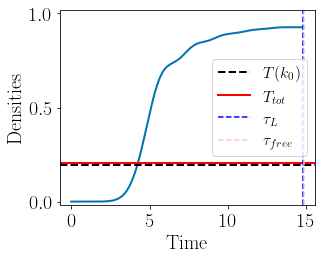

In [101]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

plt.plot(times, n_right,linewidth=2)

ax.axhline(T0, linestyle='dashed',c="black", label= r"$T(k_0)$", linewidth=2)
ax.axhline(T_tot, linestyle='solid',c="red", label= r"$T_{tot}$", linewidth=2)

ax.axvline(tau_L, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax.axvline(tau_free, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

plt.ylim(-0.02,1.02)
#plt.xlim(min(times),max(times))


plt.xlabel('Time')
plt.ylabel("Densities")
plt.legend()

plt.tight_layout()
"""
plt.savefig(fig_route+"scattering_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))
"""


# Constant $t$ , $k$ and variable $\Omega$

here we always look at $\Omega = {0.1, 0.5,1.0 }$


In [ ]:
Lqpc = 14
maxtime = 10.0
bw = 1.5
k0 = 2.0
jp = 1.0
t = 0.2
dd_init = "second"
file_list = [
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.1_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.5_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om1.0_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            ]


In [ ]:
colors = plt.cm.Blues(np.linspace(0.4,1,len(file_list)))

tick_positions = []
omega_labels = []

fig, axd = plt.subplots(2,1,figsize=(6,7),sharex=True)

for f in range(0,len(file_list)):
    file_ = file_list[f]
    # for the double dots
    param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route, file_)
    Om = param_dict["Omega"]
    
    print(param_dict)
    
    axd[0].plot(times, n_d2, c = colors[f], alpha=0.8 ,linewidth=2.5, 
                label=r'$\Omega={}$'.format(param_dict["Omega"]))    
    
    axd[1].plot(times,n_last+(2.5*Om), linestyle="dotted",linewidth=2,c='black')
    axd[1].plot(times, n_left+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,)
    axd[1].plot(times, n_right+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashed")
    axd[1].plot(times, n_bond+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashdot")

    tick_positions.append(2.5*Om+0.5)
    omega_labels.append(Om)  
    
    # for the trajectories ----------------
    fig_traj, ax_traj = plt.subplots(1,1,figsize=(7.0,6))
    
    # plot the occupations as a heatmap with lattice site in the y axis and time on the x
    sns.heatmap(traject, ax=ax_traj)
    ax_traj.set_xlabel("steps")
    ax_traj.set_ylabel("densities")
    ax_traj.axhline(param_dict["bond_index"]+1,c='blue')

    site_ticks = list(range(0,13)) + ["d1","d2"]
    tick_pos = np.asarray(range(0,15)) + 0.5

    ax_traj.set_yticks(tick_pos,site_ticks);
    fig_traj.tight_layout()
    """fig_traj.savefig("../plots/QPC_double_dot/traj_L={:.2f}_tdot={:.2f}_K={}_Jp={}_dd_{}_om={}.png".format(Lqpc, t, k0,jp,
                                                                                                           dd_init,Om),
                         dpi=400)"""
    
axd[1].plot(0,0,linestyle="dotted",linewidth=2.0,label='Last', c='black')
axd[1].plot(0,0,linestyle="solid",linewidth=2.5,label='Left', c=colors[1])
axd[1].plot(0,0,linestyle="dashed",linewidth=2.5,label='Right',c=colors[1])
axd[1].plot(0,0,linestyle="dashdot",linewidth=2.5,label='bond',c=colors[1])


# analytic expectation for decoupled case
rabi_osc = np.sin(t*times)**2

axd[0].plot(times, rabi_osc, linewidth=5, alpha=0.8, c='red' ,label=r"$\Omega = 0$",zorder=0)

axd[0].set_title(r"$t = {}, k = {}, J_p={}$".format(t,k0, jp))
axd[0].legend()
axd[0].set_ylabel(r"$n_{d1}$")
axd[0].set_box_aspect(1/3.5)
axd[0].xaxis.set_ticks_position('none') 

axd[1].set_xlabel(r"Time")
axd[1].set_ylabel(r"$\Omega / n_{s}$")
axd[1].set_yticks(tick_positions, omega_labels)
axd[1].legend()
fig.subplots_adjust(hspace=-0.62)


"""fig.tight_layout()
fig.savefig("../plots/QPC_double_dot/density_sums_L={:.2f}_tdot={:.2f}_K={}_Jp={}_bw={}_dd_{}.pdf".format(Lqpc, t,
                                                                                                 k0,jp,bw,dd_init))
"""